# 1. Background information on the dataset

## Features of Dataset

1. **Gender**: (0: 'Female', 1: 'Male')
2. **Age**: Patient's age in years.
3. **Hypertension**: (0 : No history of hypertension, 1: History of hypertension)
4. **Heart Disease**: (0: No history of heart disease, 1: History of heart disease)
5. **Ever Married**: (0: Patient has not been married before, 1: Patient has been married before)
6. **Work Type**: (0: 'Govt_job', 1: 'Never_worked', 2: 'Private', 3: 'Self-employed', 4: 'children')
7. **Residence Type**: (0: 'Rural', 1: 'Urban')
8. **Average Glucose Level**: Numeric data representing the average patient's glucose level.
9. **BMI**: Numeric data representing Body Mass Index.
10. **Smoking Status**: (0: 'Unknown', 1: 'formerly smoked', 2: 'never smoked', 3: 'smokes')

Before data cleaning, there were 5110 rows of data. However, there were "NaN" values under "BMI" and an anomaly of "Other" under "Gender". Hence, after data cleaning, we are left with 4908 rows of data.

## Objective

Our primary goal is to develop a predictive model that accurately identifies individuals at risk of experiencing a stroke based on various demographic, lifestyle, and health-related factors provided in the dataset.

# 2. Libraries and packages

## Tools and Libraries

For this project, we will utilize Python along with the following libraries for data analysis, machine learning, and data visualization. Below are the main libraries we will be using:

- **Pandas**: Used for data manipulation and analysis.
- **Matplotlib** and **Seaborn**: Employed for data visualization tasks.
- **Scikit-learn**: Utilized for various machine learning tasks such as data preprocessing, model training, and evaluation.
- **Imbalanced-learn**: Employed for addressing class imbalance issues within the dataset.


In [1]:
# Importing necessary packages
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# Set seaborn style
sb.set()

# Import models and tools from Scikit-Learn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the data set
traindata = pd.read_csv('cleaned_data.csv')
traindata.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,1,80.0,0,1,1,2,0,105.92,32.5,2,1
2,0,49.0,0,0,1,2,1,171.23,34.4,3,1
3,0,79.0,1,0,1,3,0,174.12,24.0,2,1
4,1,81.0,0,0,1,2,1,186.21,29.0,1,1


# 2. Exploratory data analysis

In [3]:
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married',
'work_type', 'Residence_type', 'smoking_status']

numerical = ['age', 'avg_glucose_level', 'bmi']

## 2.1 Univariate analysis

In [4]:
# Extract only the numeric data variables
numeric_data = pd.DataFrame(traindata[numerical])
numeric_data.describe().round(2)

,age,avg_glucose_level,bmi
count,4908.00,4908.00,4908.00
mean,42.87,105.30,28.89
std,22.56,44.43,7.85
min,0.08,55.12,10.30
25%,25.00,77.07,23.50
50%,44.00,91.68,28.10
75%,60.00,113.50,33.10
max,82.00,271.74,97.60


Based on the mean and median score differences, we can expect

1. Slightly left skew on the `age` (mean: 42.87 & median: 44)\
2.  Right skew distribution on the `avg_glucose_level` (mean: 105.30 & median: 91.68)
3. Slightly right skew on the `bmi` (mean: 28.89 & median: 28.10)

In [5]:
numeric_data[numerical].skew()

age                 -0.119450
avg_glucose_level    1.614619
bmi                  1.055063
dtype: float64

From the results, we can observe that `age` has a slight left skew, while the other two features have a right tail, positively skewed shape distribution.

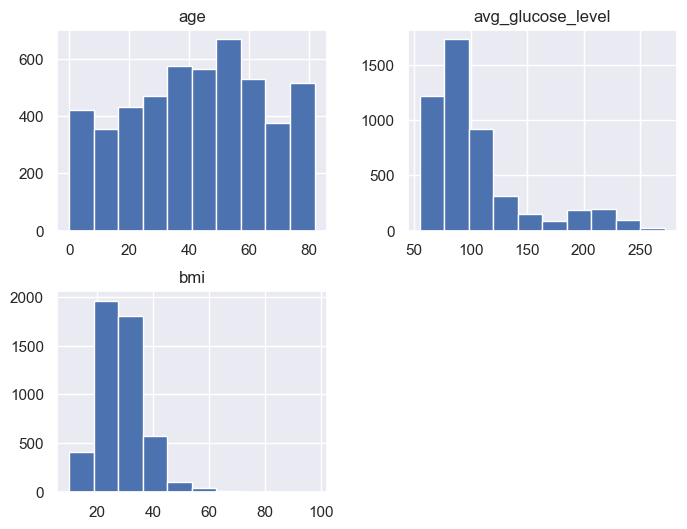

In [6]:
numeric_data[numerical].hist(figsize=(8,6));

As seen from the histograms, numerical features have skewness in different degrees. This aligns with what we expected above.

### 2.1.1 Stroke

In [7]:
stroke_counts = traindata['stroke'].value_counts()
print(stroke_counts)

stroke
0    4699
1     209
Name: count, dtype: int64


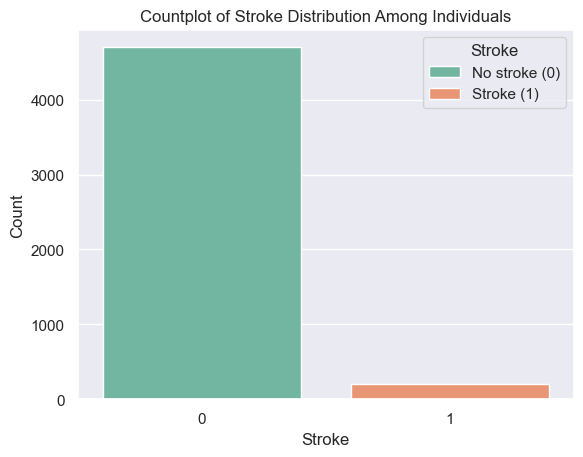

Individuals with no stroke (0):	95.74%
Individuals with stroke (1):	4.26%

Column Name:	stroke
Data Type:	int64


In [8]:
# Barplot to represent gender counts
ax = sb.countplot(data=traindata, x='stroke', orient='h', palette='Set2')

plt.xlabel('Stroke')
plt.ylabel('Count')

# Manually create legend
handles = ax.patches
labels = ['No stroke (0)', 'Stroke (1)']
plt.legend(handles, labels, title="Stroke")

plt.title("Countplot of Stroke Distribution Among Individuals")
plt.show()

# Print percentages of female and male
stroke_counts = traindata['stroke'].value_counts(normalize=True) * 100
no_stroke_percentage = stroke_counts[0] if 0 in stroke_counts.index else 0
stroke_percentage = stroke_counts[1] if 1 in stroke_counts.index else 0
print(f'Individuals with no stroke (0):\t{no_stroke_percentage:.2f}%')
print(f'Individuals with stroke (1):\t{stroke_percentage:.2f}%')
print()

# Print column name and dtype
column_name = 'stroke'
column_dtype = traindata[column_name].dtype
print(f"Column Name:\t{column_name}")
print(f"Data Type:\t{column_dtype}")

From the countplot, we observed that the pecentage of individuals who did not experience stroke is significantly higher than the number of indivudals who experienced stroke, 95.74% and 4.26%, respectively. Hence, this is clearly a class imbalance problem where the distribution of stroke data is skewed/biased towards non-stroke patients. This could lead to a bias in the trained model, which can negatively impact performance. We will address this further later.

In our example, people who had a stoke is the minority class while people who did not experience a stroke is the majority class. We are interested in getting better prediction results on the minority class.

### 2.1.2 Gender

In [9]:
gender_counts = traindata['gender'].value_counts()
print(gender_counts)

gender
0    2897
1    2011
Name: count, dtype: int64


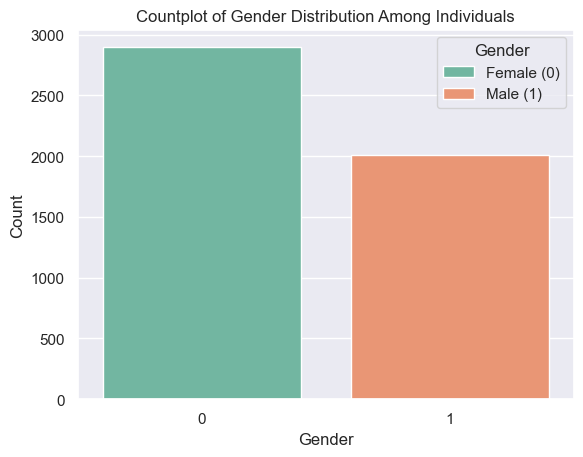

Female (0):	59.03%
Male (1):	40.97%

Column Name:	gender
Data Type:	int64


In [10]:
# Barplot to represent gender counts
ax = sb.countplot(data=traindata, x='gender', orient='h', palette='Set2')

plt.xlabel('Gender')
plt.ylabel('Count')

# Manually create legend
handles = ax.patches
labels = ['Female (0)', 'Male (1)']
plt.legend(handles, labels, title="Gender")

plt.title("Countplot of Gender Distribution Among Individuals")
plt.show()

# Print percentages of female and male
gender_counts = traindata['gender'].value_counts(normalize=True) * 100
female_percentage = gender_counts[0] if 0 in gender_counts.index else 0
male_percentage = gender_counts[1] if 1 in gender_counts.index else 0
print(f'Female (0):\t{female_percentage:.2f}%')
print(f'Male (1):\t{male_percentage:.2f}%')
print()

# Print column name and dtype
column_name = 'gender'
column_dtype = traindata[column_name].dtype
print(f"Column Name:\t{column_name}")
print(f"Data Type:\t{column_dtype}")

From the countplot and function value_counts(), our dataset has a higher female-to-male gender ratio of 2897 females to 2011 males. This converts to 59.03% females and 40.97% males.

### 2.1.3 Hypertension

In [11]:
hypertension_counts = traindata['hypertension'].value_counts()
print(hypertension_counts)

hypertension
0    4457
1     451
Name: count, dtype: int64


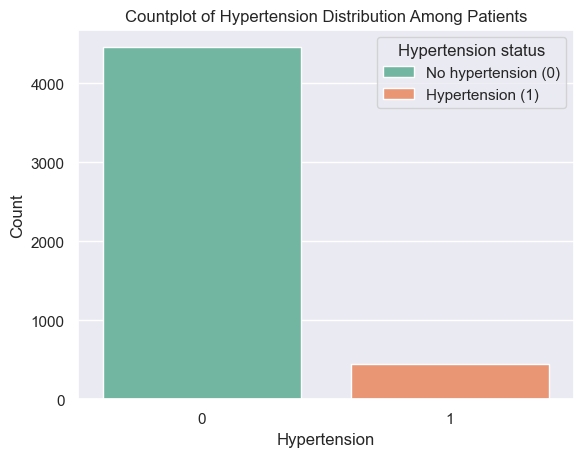

Patients without hypertension (0):	90.81%
Patients with hypertension (1):		9.19%

Column Name:	hypertension
Data Type:	int64


In [12]:
# Barplot to represent hypertension counts
ax = sb.countplot(data=traindata, x='hypertension', orient='h', palette='Set2')

plt.xlabel('Hypertension')
plt.ylabel('Count')

# Manually create legend
handles = ax.patches
labels = ['No hypertension (0)', 'Hypertension (1)']
plt.legend(handles, labels, title="Hypertension status")

plt.title("Countplot of Hypertension Distribution Among Patients")
plt.show()

# Calculate the percentage of patients with hypertension
hypertension_counts = traindata['hypertension'].value_counts(normalize=True) * 100
hypertension_percentage = hypertension_counts[1] if 1 in hypertension_counts.index else 0
no_hypertension_percentage = hypertension_counts[0] if 0 in hypertension_counts.index else 0

print(f'Patients without hypertension (0):\t{no_hypertension_percentage:.2f}%')
print(f'Patients with hypertension (1):\t\t{hypertension_percentage:.2f}%')
print()

# Print column name and dtype
column_name = 'hypertension'
column_dtype = traindata[column_name].dtype
print(f"Column Name:\t{column_name}")
print(f"Data Type:\t{column_dtype}")

Based on the countplot and the result of the function value_counts(), our dataset indicates that there are 451 patients with hypertension and 4457 patients without hypertension. This distribution represents approximately 9.19% and 90.81% of the total number of patients, respectively.

### 2.1.4 Heart disease

In [13]:
heartDisease_counts = traindata['heart_disease'].value_counts()
print(heartDisease_counts)

heart_disease
0    4665
1     243
Name: count, dtype: int64


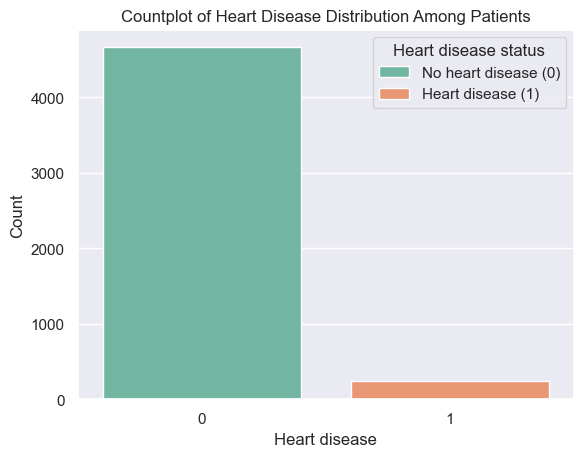

Patients without heart disease (0):	95.05%
Patients with heart disease (1):	4.95%

Column Name:	heart_disease
Data Type:	int64


In [14]:
# Barplot to represent heart disease counts
ax = sb.countplot(data=traindata, x='heart_disease', orient='h', palette='Set2')

plt.xlabel('Heart disease')
plt.ylabel('Count')

# Manually create legend
handles = ax.patches
labels = ['No heart disease (0)', 'Heart disease (1)']
plt.legend(handles, labels, title="Heart disease status")

plt.title("Countplot of Heart Disease Distribution Among Patients")
plt.show()

# Calculate the percentage of patients with hypertension
heartDisease_counts = traindata['heart_disease'].value_counts(normalize=True) * 100
heartDisease_percentage = heartDisease_counts[1] if 1 in heartDisease_counts.index else 0
no_heartDisease_percentage = heartDisease_counts[0] if 0 in heartDisease_counts.index else 0

print(f'Patients without heart disease (0):\t{no_heartDisease_percentage:.2f}%')
print(f'Patients with heart disease (1):\t{heartDisease_percentage:.2f}%')
print()

# Print column name and dtype
column_name = 'heart_disease'
column_dtype = traindata[column_name].dtype
print(f"Column Name:\t{column_name}")
print(f"Data Type:\t{column_dtype}")

Based on the countplot and the result of the function value_counts(), our dataset indicates that there are 243 patients with heart disease and 4665 patients without heart disease. This distribution represents approximately 4.95% and 95.05% of the total number of patients, respectively.

Majority of the people in our dataset do not have heart disease, almost 19 times more than those with heart disease.

### 2.1.5 Married

In [15]:
everMarried_counts = traindata['ever_married'].value_counts()
print(everMarried_counts)

ever_married
1    3204
0    1704
Name: count, dtype: int64


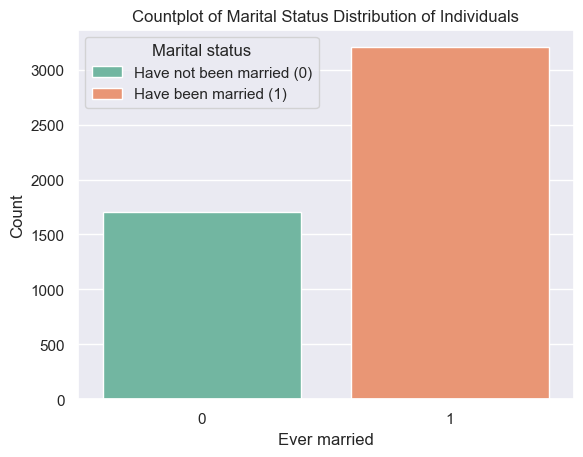

Individuals who have never been married before (0):	34.72%
Individuals who have been married before (1):		65.28%

Column Name:	ever_married
Data Type:	int64


In [16]:
# Barplot to represent ever married counts
ax = sb.countplot(data=traindata, x='ever_married', orient='h', palette='Set2')

plt.xlabel('Ever married')
plt.ylabel('Count')

# Manually create legend
handles = ax.patches
labels = ['Have not been married (0)', 'Have been married (1)']
plt.legend(handles, labels, title="Marital status")

plt.title("Countplot of Marital Status Distribution of Individuals")
plt.show()

# Calculate the percentage of patients with hypertension
everMarried_counts = traindata['ever_married'].value_counts(normalize=True) * 100
everMarried_percentage = everMarried_counts[1] if 1 in everMarried_counts.index else 0
no_everMarried_percentage = everMarried_counts[0] if 0 in everMarried_counts.index else 0

print(f'Individuals who have never been married before (0):\t{no_everMarried_percentage:.2f}%')
print(f'Individuals who have been married before (1):\t\t{everMarried_percentage:.2f}%')
print()

# Print column name and dtype
column_name = 'ever_married'
column_dtype = traindata[column_name].dtype
print(f"Column Name:\t{column_name}")
print(f"Data Type:\t{column_dtype}")

After examining the countplot and the outcome of the value_counts() function, it's apparent that our dataset comprises 1704 individuals who have never married and 3204 individuals who have been married. This distribution roughly represents approximately 34.72% and 65.28% of the total population of individuals respectively, based on whether they have been married or not.

### 2.1.6 Work type

In [17]:
workType_counts = traindata['work_type'].value_counts().sort_index()
print(workType_counts)

work_type
0     630
1      22
2    2810
3     775
4     671
Name: count, dtype: int64


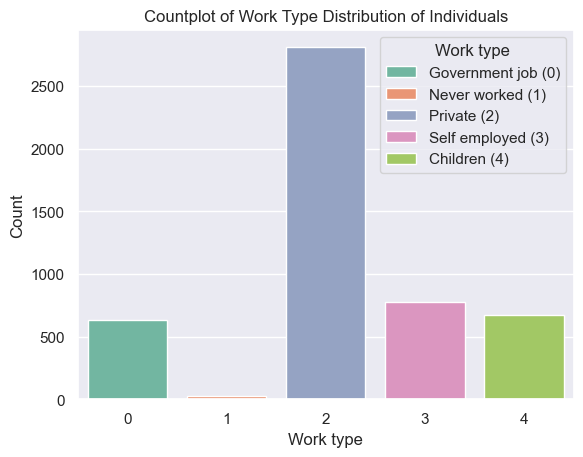

Individuals working in government sectors (0):	12.84%
Individuals who never worked (1):		0.45%
Individuals working in private sectors (2):	57.25%
Individuals who are self employed (3):		15.79%
Individuals who are children (4):		13.67%

Column Name:	work_type
Data Type:	int64


In [18]:
# Barplot to represent work type counts
ax = sb.countplot(data=traindata, x='work_type', orient='h', palette='Set2')

plt.xlabel('Work type')
plt.ylabel('Count')

# Manually create legend
handles = ax.patches
labels = ['Government job (0)', 'Never worked (1)', 'Private (2)', 'Self employed (3)', 'Children (4)']
plt.legend(handles, labels, title="Work type")

plt.title("Countplot of Work Type Distribution of Individuals")
plt.show()


# Calculate the percentage of patients with each work type
workType_counts = traindata['work_type'].value_counts(normalize=True) * 100
print(f"Individuals working in government sectors (0):\t{workType_counts.get(0, 0):.2f}%")
print(f"Individuals who never worked (1):\t\t{workType_counts.get(1, 0):.2f}%")
print(f"Individuals working in private sectors (2):\t{workType_counts.get(2, 0):.2f}%")
print(f"Individuals who are self employed (3):\t\t{workType_counts.get(3, 0):.2f}%")
print(f"Individuals who are children (4):\t\t{workType_counts.get(4, 0):.2f}%")
print()

# Print column name and dtype
column_name = 'work_type'
column_dtype = traindata[column_name].dtype
print(f"Column Name:\t{column_name}")
print(f"Data Type:\t{column_dtype}")

After analyzing the countplot and the results of the value_counts() function, it becomes evident that the majority of individuals in our dataset are employed in the private sector, totaling 2810 individuals, which corresponds to 57.25% of the dataset. Following this, 775 individuals, or 15.79%, are self-employed, while 671 individuals, accounting for 13.67%, are children.

### 2.1.7 Residence type

In [19]:
residenceType_counts = traindata['Residence_type'].value_counts()
print(residenceType_counts)

Residence_type
1    2490
0    2418
Name: count, dtype: int64


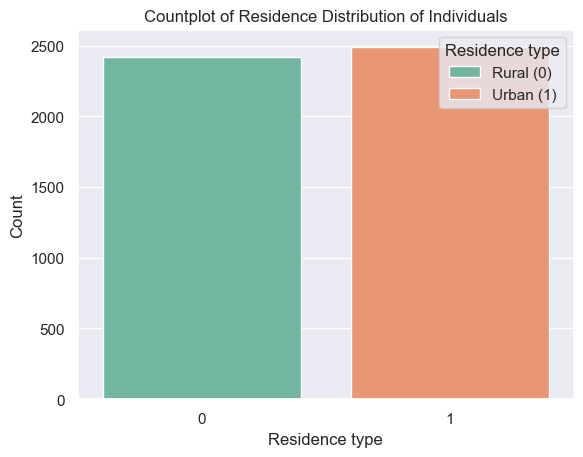

Individuals living in rural areas (0):	49.27%
Individuals living in urban areas (1):	50.73%

Column Name:	Residence_type
Data Type:	int64


In [20]:
# Barplot to represent ever married counts
ax = sb.countplot(data=traindata, x='Residence_type', orient='h', palette='Set2')

plt.xlabel('Residence type')
plt.ylabel('Count')

# Manually create legend
handles = ax.patches
labels = ['Rural (0)', 'Urban (1)']
plt.legend(handles, labels, title="Residence type")

plt.title("Countplot of Residence Distribution of Individuals")
plt.show()

# Calculate the percentage of patients with hypertension
residenceType_counts = traindata['Residence_type'].value_counts(normalize=True) * 100
urban_percentage = residenceType_counts[1] if 1 in residenceType_counts.index else 0
rural_percentage = residenceType_counts[0] if 0 in residenceType_counts.index else 0

print(f'Individuals living in rural areas (0):\t{rural_percentage:.2f}%')
print(f'Individuals living in urban areas (1):\t{urban_percentage:.2f}%')
print()

# Print column name and dtype
column_name = 'Residence_type'
column_dtype = traindata[column_name].dtype
print(f"Column Name:\t{column_name}")
print(f"Data Type:\t{column_dtype}")

Upon analyzing the countplot and the results of the value_counts() function, it is evident that our dataset comprises 2490 individuals residing in urban areas and 2418 individuals residing in rural areas. This distribution roughly accounts for 50.73% and 49.27% of the total population, respectively, based on residence type.

### 2.1.8 Smoking status

In [21]:
smokingStatus_counts = traindata['smoking_status'].value_counts().sort_index()
print(smokingStatus_counts)

smoking_status
0    1483
1     836
2    1852
3     737
Name: count, dtype: int64


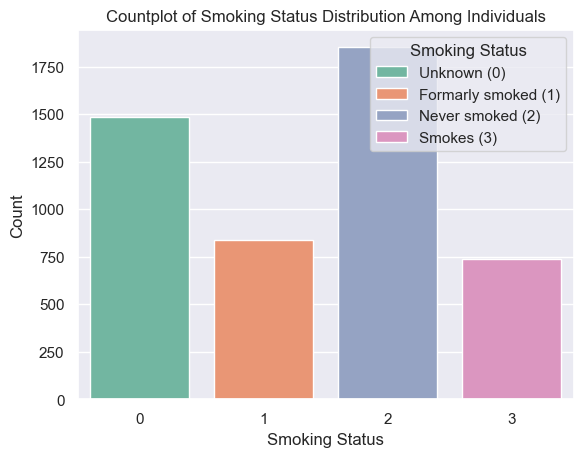

Unknown (0):		30.22%
Formerly Smoked (1):	17.03%
Never Smoked (2):	37.73%
Smokes (3):		15.02%

Column Name:	smoking_status
Data Type:	int64


In [22]:
# Barplot to represent smoking status counts
ax = sb.countplot(data=traindata, x='smoking_status', palette='Set2')

plt.xlabel('Smoking Status')
plt.ylabel('Count')

# Manually create legend
handles = ax.patches
labels = ['Unknown (0)', 'Formarly smoked (1)', 'Never smoked (2)', 'Smokes (3)']
plt.legend(handles, labels, title="Smoking Status")

plt.title("Countplot of Smoking Status Distribution Among Individuals")
plt.show()

# Calculate the percentage of patients with each smoking status
smokingStatus_counts = traindata['smoking_status'].value_counts(normalize=True) * 100
unknown_percentage = smokingStatus_counts.get(0, 0)
formerly_smoked_percentage = smokingStatus_counts.get(1, 0)
never_smoked_percentage = smokingStatus_counts.get(2, 0)
smokes_percentage = smokingStatus_counts.get(3, 0)

print(f'Unknown (0):\t\t{unknown_percentage:.2f}%')
print(f'Formerly Smoked (1):\t{formerly_smoked_percentage:.2f}%')
print(f'Never Smoked (2):\t{never_smoked_percentage:.2f}%')
print(f'Smokes (3):\t\t{smokes_percentage:.2f}%')
print()

# Print column name and dtype
column_name = 'smoking_status'
column_dtype = traindata[column_name].dtype
print(f"Column Name:\t{column_name}")
print(f"Data Type:\t{column_dtype}")

Upon analyzing the countplot and the results of the value_counts() function, it is evident that the majority of individuals in our dataset, comprising 1852 people (37.73%), have never smoked. This group constitutes the largest portion of our dataset. Additionally, 1483 individuals (30.22%) lack smoking information, 836 individuals (17.03%) are former smokers, followed by 737 individuals (15.02%) who currently smoke.

It is noteworthy that the number of individuals who never smoked is approximately equivalent to the sum of the number of individuals who formerly smoked and those who currently smoke.

## 2.2 Bivariate analysis

Based on domain knowledge and relevance to predicting strokes, we will skip conducting bivariate analysis for the `Residence_type` and `work_type` features. These features are typically less directly associated with stroke occurrence compared to factors such as `age`, `hypertension`, or `smoking_status` etc.

### 2.2.1 Exploring the relationship between 'hypertension' and 'stroke'

In [23]:
pd.crosstab(traindata.stroke, traindata.hypertension)

hypertension,0,1
stroke,,
0,4308,391
1,149,60


In [24]:
pd.crosstab(traindata.stroke, traindata.hypertension, normalize='columns')

hypertension,0,1
stroke,,
0,0.966569,0.866962
1,0.033431,0.133038


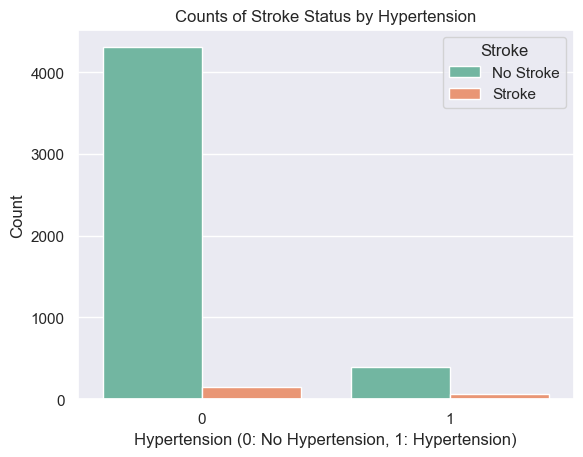

In [25]:
# Create a bar plot of hypertension vs non-hypertension with stroke status
sb.countplot(x='hypertension', data=traindata, hue='stroke', palette='Set2')
plt.title("Counts of Stroke Status by Hypertension")
plt.ylabel('Count')
plt.xlabel('Hypertension (0: No Hypertension, 1: Hypertension)')
plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'], loc='upper right')
plt.show()

In [26]:
# Probability of stroke for individuals with and without hypertension
stroke_probability_hypertension = traindata[traindata["hypertension"] == 1]["stroke"].mean() * 100
stroke_probability_no_hypertension = traindata[traindata["hypertension"] == 0]["stroke"].mean() * 100

print(f"A person with hypertension has a probability of {round(stroke_probability_hypertension, 2)}% to get a stroke.")
print(f"A person without hypertension has a probability of {round(stroke_probability_no_hypertension, 2)}% to get a stroke.")

A person with hypertension has a probability of 13.3% to get a stroke.
A person without hypertension has a probability of 3.34% to get a stroke.


Based on the analysis of the countplot, it can be inferred that there is a strong correlation between 'hypertension' and 'stroke'. The probability of an individual with hypertension experiencing a stroke is approximately 13.3%, whereas the probability for an individual without hypertension is approximately 3.34%. This suggests a potential association, indicating that individuals with a history of hypertension may have a higher likelihood of experiencing a stroke.

In other words, a person with hypertension is 3.9 times more likely to get a stroke than those who do not have hypertension. Hence, we can conclude that high blood pressure (hypertension) increases the likelihood of a stroke.

### 2.2.2 Exploring the relationship between 'gender' and 'stroke'

In [27]:
pd.crosstab(traindata.stroke, traindata.gender)

gender,0,1
stroke,,
0,2777,1922
1,120,89


In [28]:
pd.crosstab(traindata.stroke, traindata.gender, normalize='columns')

gender,0,1
stroke,,
0,0.958578,0.955743
1,0.041422,0.044257


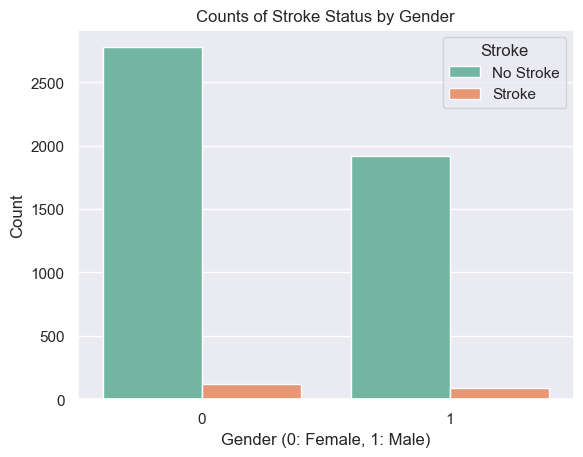

In [29]:
# Create a bar plot of gender with stroke status
sb.countplot(x='gender', data=traindata, hue='stroke', palette='Set2')
plt.title("Counts of Stroke Status by Gender")
plt.ylabel('Count')
plt.xlabel('Gender (0: Female, 1: Male)')
plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'], loc='upper right')
plt.show()

In [30]:
# Probability of stroke for each gender
stroke_probability_female = traindata[traindata["gender"] == 0]["stroke"].mean() * 100
stroke_probability_male = traindata[traindata["gender"] == 1]["stroke"].mean() * 100

print(f"The probability of a female having a stroke is {round(stroke_probability_female, 2)}%.")
print(f"The probability of a male having a stroke is {round(stroke_probability_male, 2)}%.")

The probability of a female having a stroke is 4.14%.
The probability of a male having a stroke is 4.43%.


Based on the analysis from the countplot, it appears that there is no significant correlation between 'gender' and 'stroke'. While the probability of a female individual experiencing a stroke is 4.14%, slightly lower than the probability of a male experiencing a stroke, which is 4.43%, the difference between these probabilities is relatively small. Therefore, gender alone may not be a reliable determinant for the likelihood of experiencing a stroke. Further investigation into additional factors may be necessary to better understand the risk factors associated with stroke.

### 2.2.3 Exploring the relationship between 'heart_disease' and 'stroke'

In [31]:
pd.crosstab(traindata.stroke, traindata.heart_disease)

heart_disease,0,1
stroke,,
0,4496,203
1,169,40


In [32]:
pd.crosstab(traindata.stroke, traindata.heart_disease, normalize='columns')

heart_disease,0,1
stroke,,
0,0.963773,0.835391
1,0.036227,0.164609


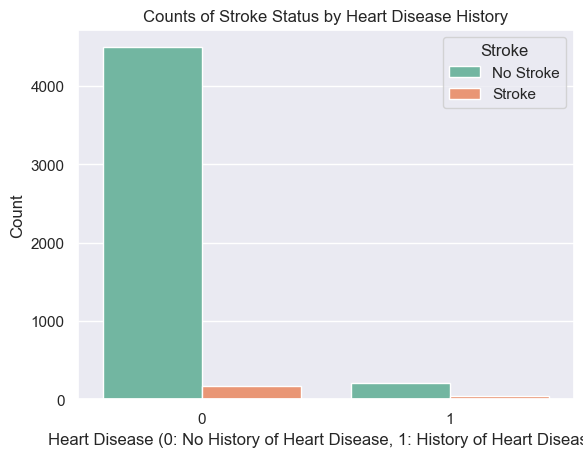

In [33]:
# Create a bar plot of heart disease with stroke status
sb.countplot(x='heart_disease', data=traindata, hue='stroke', palette='Set2')
plt.title("Counts of Stroke Status by Heart Disease History")
plt.ylabel('Count')
plt.xlabel('Heart Disease (0: No History of Heart Disease, 1: History of Heart Disease)')
plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'], loc='upper right')
plt.show()

In [34]:
# Probability of stroke for individuals with and without heart disease
stroke_probability_with_heart_disease = traindata[traindata["heart_disease"] == 1]["stroke"].mean() * 100
stroke_probability_without_heart_disease = traindata[traindata["heart_disease"] == 0]["stroke"].mean() * 100

print(f"The probability of having a stroke for individuals with heart disease is {round(stroke_probability_with_heart_disease, 2)}%.")
print(f"The probability of having a stroke for individuals without heart disease is {round(stroke_probability_without_heart_disease, 2)}%.")

The probability of having a stroke for individuals with heart disease is 16.46%.
The probability of having a stroke for individuals without heart disease is 3.62%.


Based on our analysis from the countplot, it appears that there is a significant correlation between 'heart_disease' and 'stroke'. The probability of having a stroke for individuals with heart disease is 16.46%, which is notably higher than the probability of having a stroke for individuals without heart disease, which stands at 3.62%. This suggests that individuals with heart disease are approximately 4.5 times more likely to suffer from a stroke compared to those without heart disease.

### 2.2.4 Exploring the relationship between 'ever_married' and 'stroke'

In [35]:
# Removing people under 20 years old
everMarried_stroke_data = traindata[traindata.age >= 20]

Based on our research of the median marital age, we discovered that people who got married between 1950 to 1970 were around 23 years old for males and 20 years old for females. The reason we looked at past data was because our dataset consists of people aged up to 82 years old which could fall within this median marital age. Hence, we removed the people under 20 years old because they are probably not married before that.

In [36]:
pd.crosstab(everMarried_stroke_data.stroke, everMarried_stroke_data.ever_married)

ever_married,0,1
stroke,,
0,741,3015
1,22,186


In [37]:
pd.crosstab(everMarried_stroke_data.stroke, everMarried_stroke_data.ever_married, normalize='columns')

ever_married,0,1
stroke,,
0,0.971166,0.941893
1,0.028834,0.058107


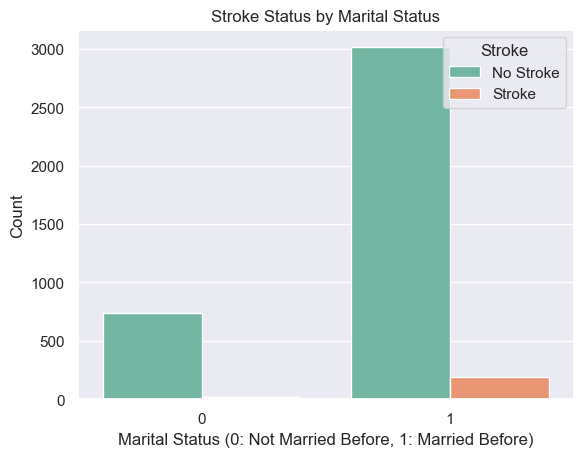

In [38]:
# Create a bar plot of marital status with stroke status
sb.countplot(x='ever_married', data=everMarried_stroke_data, hue='stroke', palette='Set2')
plt.title("Stroke Status by Marital Status")
plt.ylabel('Count')
plt.xlabel('Marital Status (0: Not Married Before, 1: Married Before)')
plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'], loc='upper right')
plt.show()

In [39]:
# Probability of stroke for individuals with their marital status
stroke_probability_ever_married = everMarried_stroke_data[everMarried_stroke_data["ever_married"] == 1]["stroke"].mean() * 100
stroke_probability_not_ever_married = everMarried_stroke_data[everMarried_stroke_data["ever_married"] == 0]["stroke"].mean() * 100

print(f"The probability of having a stroke for individuals who have ever been married is {round(stroke_probability_ever_married, 2)}%.")
print(f"The probability of having a stroke for individuals who have never been married is {round(stroke_probability_not_ever_married, 2)}%.")

The probability of having a stroke for individuals who have ever been married is 5.81%.
The probability of having a stroke for individuals who have never been married is 2.88%.


From our analysis of the countplot, it's evident that there exists a notable correlation between 'ever_married' and 'stroke'. Individuals who have been married or are currently married demonstrate a higher probability of experiencing a stroke, with 5.81%, compared to those who have never been married, which stands at 2.88%. This indicates that married individuals are roughly 2 times more likely to suffer from a stroke compared to those who have never been married.

However, it's crucial to note that while there appears to be a correlation between these two features, marital status alone might not be the sole determinant of stroke risk. Other factors, such as age and overall health condition, could also play significant roles. For instance, married individuals may tend to be older, and with age, the likelihood of experiencing health issues, including stroke, may increase. Therefore, it's important to consider these factors collectively rather than attributing stroke risk solely to marital status.

### 2.2.5 Exploring the relationship between 'smoking_status' and 'stroke'

In [40]:
pd.crosstab(traindata.stroke, traindata.smoking_status)

smoking_status,0,1,2,3
stroke,,,,
0,1454,779,1768,698
1,29,57,84,39


In [41]:
pd.crosstab(traindata.stroke, traindata.smoking_status, normalize='columns')

smoking_status,0,1,2,3
stroke,,,,
0,0.980445,0.931818,0.954644,0.947083
1,0.019555,0.068182,0.045356,0.052917


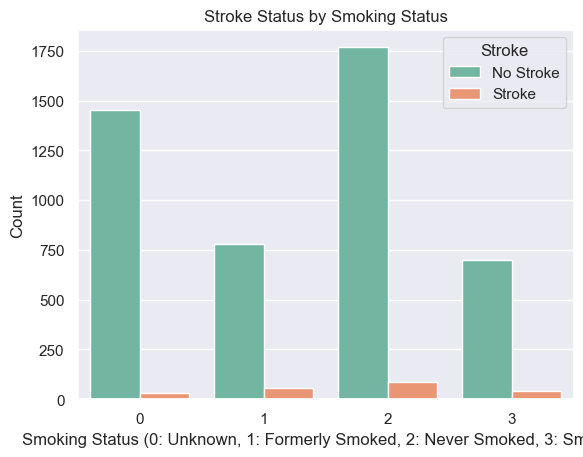

In [42]:
# Create a bar plot of marital status with stroke status
sb.countplot(x='smoking_status', data=traindata, hue='stroke', palette='Set2')
plt.title("Stroke Status by Smoking Status")
plt.ylabel('Count')
plt.xlabel('Smoking Status (0: Unknown, 1: Formerly Smoked, 2: Never Smoked, 3: Smokes)')
plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'], loc='upper right')
plt.show()

In [43]:
# Probability of stroke for individuals with their smoking status
stroke_probability_unknown = traindata[traindata["smoking_status"] == 0]["stroke"].mean() * 100
stroke_probability_formerly_smoked = traindata[traindata["smoking_status"] == 1]["stroke"].mean() * 100
stroke_probability_never_smoked = traindata[traindata["smoking_status"] == 2]["stroke"].mean() * 100
stroke_probability_smokes = traindata[traindata["smoking_status"] == 3]["stroke"].mean() * 100

print(f"The probability of having a stroke for individuals who lack smoking information is {round(stroke_probability_unknown, 2)}%.")
print(f"The probability of having a stroke for individuals who formerly smoked is {round(stroke_probability_formerly_smoked, 2)}%.")
print(f"The probability of having a stroke for individuals who never smoked is {round(stroke_probability_never_smoked, 2)}%.")
print(f"The probability of having a stroke for individuals who currently smoke is {round(stroke_probability_smokes, 2)}%.")

The probability of having a stroke for individuals who lack smoking information is 1.96%.
The probability of having a stroke for individuals who formerly smoked is 6.82%.
The probability of having a stroke for individuals who never smoked is 4.54%.
The probability of having a stroke for individuals who currently smoke is 5.29%.


Based on the countplot, there appears to be a positive association between 'smoking_status' and 'stroke'. Individuals who formerly smoked have a stroke probability of 6.82%, while those who currently smoke have a probability of 5.29%. Combined, these groups exhibit a total probability of stroke at 12.11%. In contrast, individuals who have never smoked show a lower stroke probability of 4.54%. This suggests that smokers have a 2.6 times higher likelihood of experiencing a stroke compared to non-smokers.


It is evident that smoking is harmful for our health and can contribute to many diseases overtime. There are several reasons why individual who smoke have a higher likelihood of experiencing stroke. This could be due to the increase in blood pressure in smokers, which is a significant risk factor for stroke. Nicotine in tobacco can cause blood vessels to constrict, raising blood pressure levels over time. This is prevalent in those who formerly smoked as well. The cumulative effects of smoking for many years increases the risk of stroke due to the prolonged exposure to harmful substances in tobacco smoke.

### 2.2.6 Exploring the relationship between 'age' and 'stroke'

In [44]:
traindata['age'].describe()

count    4908.000000
mean       42.868810
std        22.556128
min         0.080000
25%        25.000000
50%        44.000000
75%        60.000000
max        82.000000
Name: age, dtype: float64

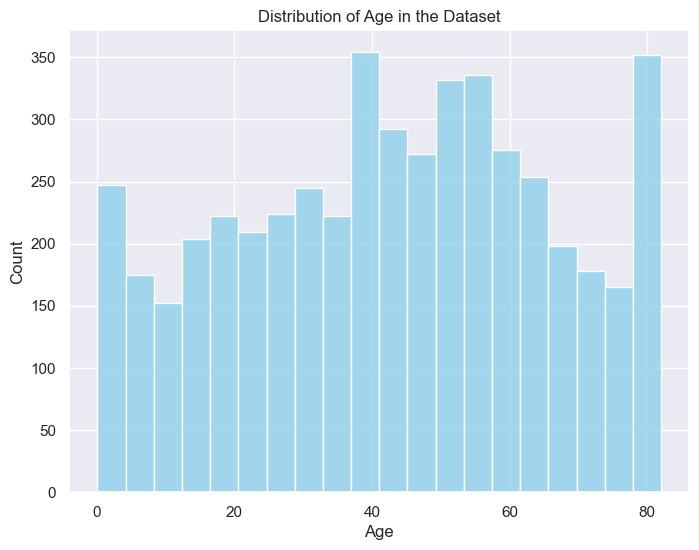

In [45]:
plt.figure(figsize=(8, 6))
sb.histplot(traindata['age'], kde=False, color='skyblue')
plt.title("Distribution of Age in the Dataset")
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

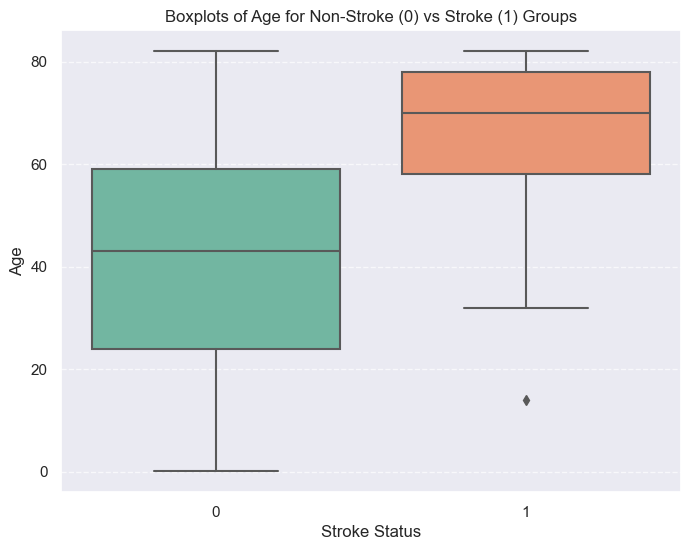

The median age of individuals with stroke is: 70.0
The median age of individuals without stroke is: 43.0


In [46]:
plt.figure(figsize=(8, 6))
sb.boxplot(data=traindata, x='stroke', y='age', palette='Set2')
plt.title("Boxplots of Age for Non-Stroke (0) vs Stroke (1) Groups")
plt.xlabel('Stroke Status')
plt.ylabel('Age')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calculate the median age for stroke and non-stroke groups
median_age_stroke = traindata[traindata['stroke'] == 1]['age'].median()
median_age_non_stroke = traindata[traindata['stroke'] == 0]['age'].median()

print(f"The median age of individuals with stroke is: {median_age_stroke}")
print(f"The median age of individuals without stroke is: {median_age_non_stroke}")

Analyzing the boxplot comparing patients with stroke (1) and those without (0), several key insights emerge. Firstly, the median age of patients with stroke stands at 70 years, notably higher than the median age of non-stroke patients, which is 43 years. This stark difference suggests that individuals aged over 70 years have a substantially elevated risk of experiencing a stroke.

Furthermore, an intriguing observation arises from comparing the interquartile ranges (IQR) of the two groups. The first quartile (Q1) of stroke patients' ages closely aligns with the third quartile (Q3) of non-stroke patients' ages. Essentially, approximately 75% of stroke patients are aged above 59 years, while 75% of non-stroke patients fall below 60 years. This finding implies that individuals aged 59 years and older may face an increased susceptibility to stroke.

Consequently, these findings highlights that stroke manifests as an age-related ailment, compounded by potential lifestyle factors. The correlation between advancing age and stroke risk underscores the importance of age-awareness in stroke prevention strategies.

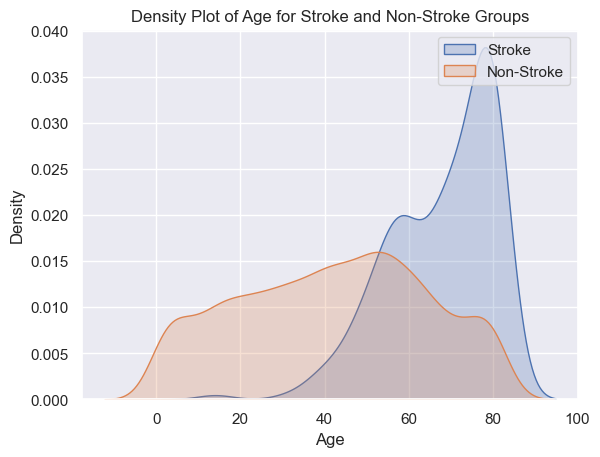

In [47]:
stroke_data = traindata[traindata['stroke'] == 1]
non_stroke_data = traindata[traindata['stroke'] == 0]

# Plot overlapping density plots for the age variable
sb.kdeplot(stroke_data['age'], label='Stroke', fill=True)
sb.kdeplot(non_stroke_data['age'], label='Non-Stroke', fill=True)

plt.title('Density Plot of Age for Stroke and Non-Stroke Groups')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

The density plot above illustrates the relationship between age and the likelihood of stroke occurrence, distinguishing between non-stroke (orange) and stroke (blue) groups. A notable observation is the wider span of the curve for non-stroke individuals, extending from approximately 20 to over 80 years old. This wider distribution suggests a greater diversity in ages among individuals without stroke.

Additionally, the curve for non-stroke patients exhibits a rightward skew, indicating that a substantial portion of individuals experiencing stroke are older in age. Particularly, there is a noticeable rise of the curve at around age 62, suggesting a concentration of stroke cases among individuals aged 62 and above. 

Furthermore, the density plot reveals a prominent peak at 76 years old, signifying the age at which stroke occurrence is most prevalent. Beyond this peak, the density plot sharply declines, indicating a reduced prevalence of stroke among individuals aged over 76 years. 

In essence, the density plot underscores the age-related nature of stroke incidence, with older individuals exhibiting a heightened vulnerability to experiencing stroke.

### 2.2.7 Exploring the relationship between 'avg_glucose_level' and 'stroke'

In [48]:
traindata['avg_glucose_level'].describe()

count    4908.000000
mean      105.297402
std        44.425550
min        55.120000
25%        77.067500
50%        91.680000
75%       113.495000
max       271.740000
Name: avg_glucose_level, dtype: float64

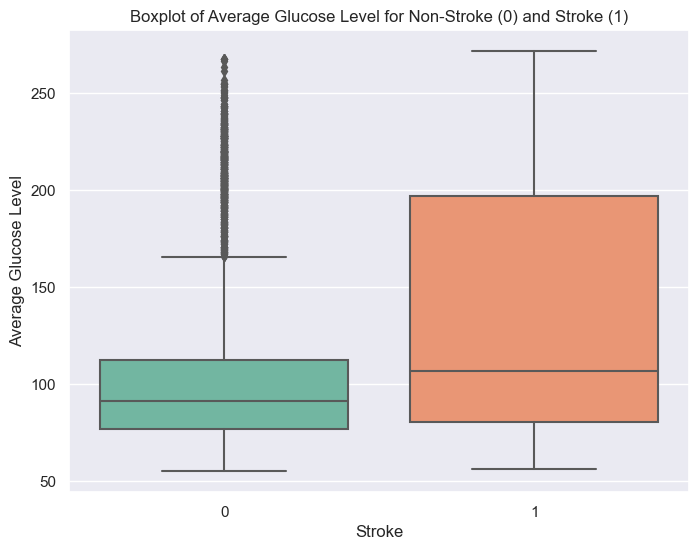

In [49]:
plt.figure(figsize=(8, 6))
sb.boxplot(data=traindata, x='stroke', y='avg_glucose_level', palette='Set2')

plt.title('Boxplot of Average Glucose Level for Non-Stroke (0) and Stroke (1)')
plt.xlabel('Stroke')
plt.ylabel('Average Glucose Level')
plt.show()

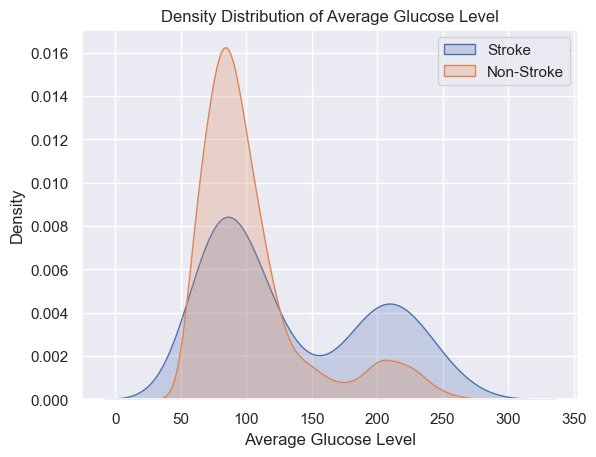

In [50]:
stroke_data = traindata[traindata['stroke'] == 1]
non_stroke_data = traindata[traindata['stroke'] == 0]

# Plot overlapping density plots for the avg_glucose_level variable
sb.kdeplot(stroke_data['avg_glucose_level'], label='Stroke', fill=True)
sb.kdeplot(non_stroke_data['avg_glucose_level'], label='Non-Stroke', fill=True)

plt.title('Density Distribution of Average Glucose Level')
plt.xlabel('Average Glucose Level')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

In [51]:
stroke_summary = traindata.groupby('stroke')['avg_glucose_level'].agg(['mean', 'median', 'std'])
print(stroke_summary)

              mean  median        std
stroke                               
0       103.995367   91.21  42.998546
1       134.571388  106.58  62.462047


Based on the boxplot and stroke summary provided, it is evident that individuals who experienced a stroke have a higher average median glucose level (134.57) compared to those who did not have a stroke (104). This suggests a notable correlation between an individual's average glucose level and the occurrence of stroke.

### 2.2.8 Exploring relationship between 'bmi' and 'stroke'

In [52]:
traindata['bmi'].describe()

count    4908.00000
mean       28.89456
std         7.85432
min        10.30000
25%        23.50000
50%        28.10000
75%        33.10000
max        97.60000
Name: bmi, dtype: float64

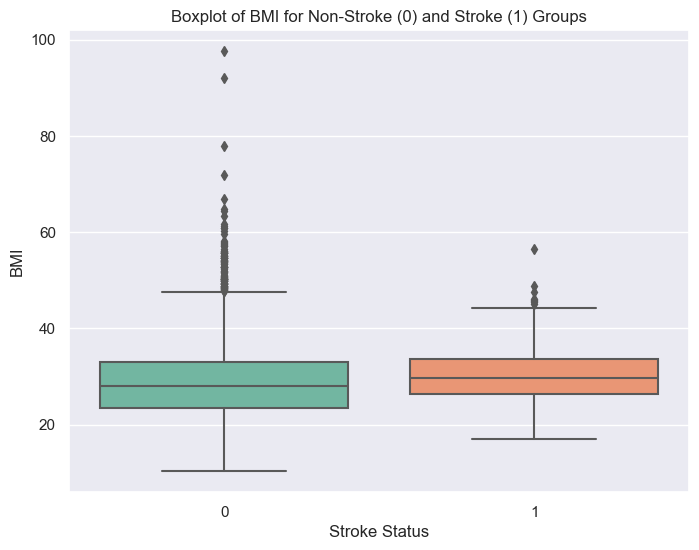

In [53]:
plt.figure(figsize=(8, 6))
sb.boxplot(data=traindata, x='stroke', y='bmi', palette='Set2')

plt.title('Boxplot of BMI for Non-Stroke (0) and Stroke (1) Groups')
plt.xlabel('Stroke Status')
plt.ylabel('BMI')

plt.show()

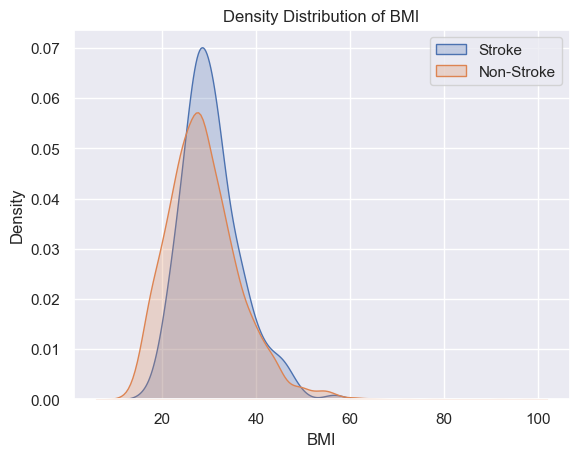

In [54]:
stroke_data = traindata[traindata['stroke'] == 1]
non_stroke_data = traindata[traindata['stroke'] == 0]

# Plot overlapping density plots for the avg_glucose_level variable
sb.kdeplot(stroke_data['bmi'], label='Stroke', fill=True)
sb.kdeplot(non_stroke_data['bmi'], label='Non-Stroke', fill=True)

plt.title('Density Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

In [55]:
bmi_summary = traindata.groupby('stroke')['bmi'].agg(['mean', 'median', 'std'])
print(bmi_summary)

             mean  median       std
stroke                             
0       28.824431    28.0  7.908573
1       30.471292    29.7  6.329452


From the boxplot comparing the body mass index (BMI) of individuals with and without stroke, there appears to be no notable correlation between BMI and stroke occurrence. The average median BMI values for both groups are quite similar, with values of approximately 28 for non-stroke individuals and 29.7 for those who have had a stroke.

Additionally, it's worth noting that the non-stroke group exhibits a higher prevalence of outliers with high BMI values.

This suggests that while BMI may not be a determining factor for stroke occurrence, the presence of outliers with high BMI in the non-stroke group could warrant further investigation into potential risk factors associated with elevated BMI.

## 2.3 Feature importance

In [56]:
categorical_factors = traindata[['gender', 'hypertension', 'heart_disease', 'ever_married', 'smoking_status']]

numerical_factors = traindata[['age','avg_glucose_level', 'bmi']]

stroke = traindata['stroke']

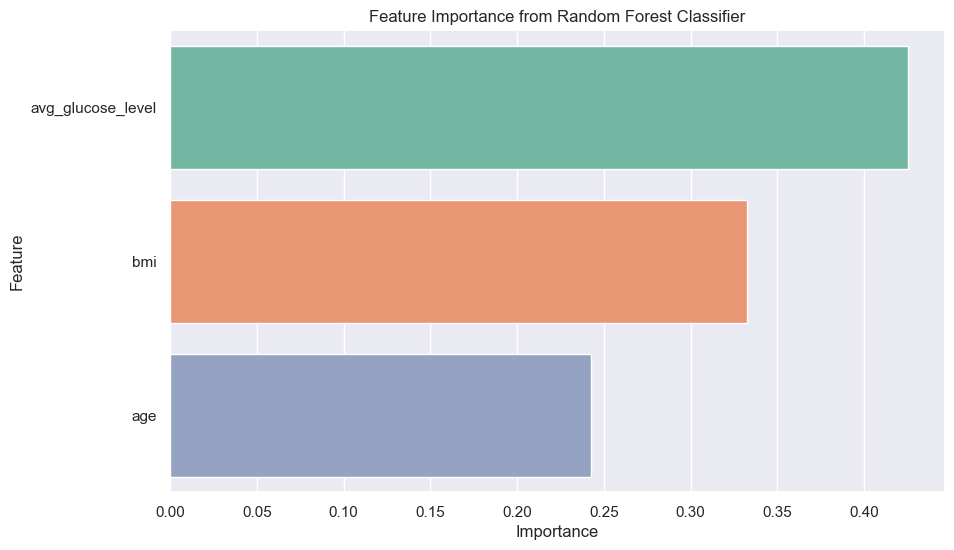

             Feature  Importance
0                age    0.242293
1  avg_glucose_level    0.425251
2                bmi    0.332456


In [57]:
# Define features and target variable
features = pd.DataFrame(traindata[["age", "avg_glucose_level", "bmi"]])
target = traindata['stroke']

# Initialize random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier
rf_classifier.fit(features, target)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sb.barplot(x='Importance', y='Feature', data=importance_df, palette='Set2')
plt.title('Feature Importance from Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Display the DataFrame
print(importance_df.sort_index())

#### Feature Importance Analysis:
This analysis aims to assess the significance of various features in predicting the target variable, which in this case is the likelihood of stroke occurrence. By employing a Random Forest Classifier, the model evaluates the importance of each feature and visualizes their relative contributions to the predictive accuracy.

The resulting visualization illustrates the importance of individual features, shedding light on their respective influences on the model's decision-making process. Features with higher importance values exert a more significant impact, guiding the model towards more accurate predictions.

In this specific analysis, the feature `avg_glucose_level` emerges as the most influential predictor of stroke occurrence, signifying its strong association with the target variable. With a feature importance value of 0.425, it demonstrates a substantial impact on the model's predictions. Following closely, `bmi` and `age` also contribute significantly, with importance values of 0.332 and 0.242, respectively.

These insights provide valuable guidance for understanding the underlying factors contributing to stroke.

### 2.3.1 Feature selection for categorical features (Chi squared test with SelectKBest)

Chi-square test results for 'gender':
Chi-square test statistic: 0.16955129804441268
p-value: 0.6805108914997836
Degrees of freedom: 1
Expected values:
stroke            0           1
gender                         
0       2773.635493  123.364507
1       1925.364507   85.635493

Chi-square test results for 'hypertension':
Chi-square test statistic: 97.23918231192063
p-value: 6.143875464115642e-23
Degrees of freedom: 1
Expected values:
stroke                  0           1
hypertension                         
0             4267.205175  189.794825
1              431.794825   19.205175

Chi-square test results for 'heart_disease':
Chi-square test statistic: 90.24989255123297
p-value: 2.0990170036138994e-21
Degrees of freedom: 1
Expected values:
stroke                 0         1
heart_disease                     
0              4466.3478  198.6522
1               232.6522   10.3478

Chi-square test results for 'ever_married':
Chi-square test statistic: 53.07579109223565
p-value: 3.20923

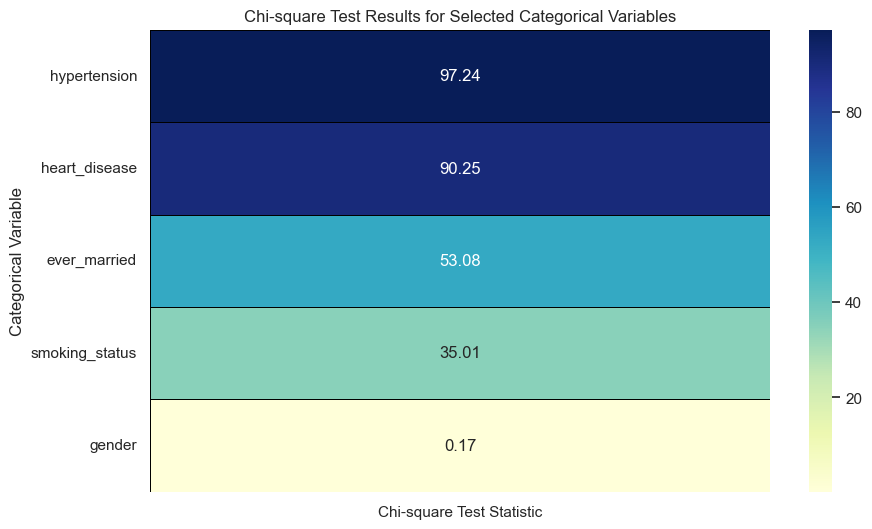

In [58]:
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called categorical_factors with categorical variables
# and another DataFrame called stroke with the outcome variable 'stroke'

# Number of features to select
k = 'all'  # Adjust as needed

# Instantiate SelectKBest with chi2 as the scoring function
selector = SelectKBest(score_func=chi2, k=k)

# Fit the selector to your data
selector.fit(categorical_factors, stroke)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = categorical_factors.columns[selected_indices]

# Store chi-square test results in a DataFrame
results = []

# Perform chi-square test for each of the selected categorical variables 
for col in selected_features:
    observed = pd.crosstab(categorical_factors[col], stroke)
    chi2_stat, p_value, dof, expected = chi2_contingency(observed)
    print(f"Chi-square test results for '{col}':")
    print('Chi-square test statistic:', chi2_stat)
    print('p-value:', p_value)
    print('Degrees of freedom:', dof)
    print('Expected values:')
    print(pd.DataFrame(expected, index=observed.index, columns=observed.columns))
    print()
    
    results.append({'Categorical Variable': col, 'Chi-square Test Statistic': chi2_stat, 'p-value': p_value})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort DataFrame by descending chi-square test scores
results_df_sorted = results_df.sort_values(by='Chi-square Test Statistic', ascending=False)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(results_df_sorted.set_index('Categorical Variable')[['Chi-square Test Statistic']], annot=True, cmap='YlGnBu', linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Chi-square Test Results for Selected Categorical Variables')
plt.ylabel('Categorical Variable')
plt.show()

As Pearson Correlation cannot be used for non-numerical variables, we employed the chi-squared test to assess the existence of a significant association between two categorical variables. This statistical test compares observed data with expected data to determine whether differences between the two are attributable to chance or to a genuine relationship between the variables.

We conducted chi-square tests for each pair of categorical variables in our dataset. For each test, we calculated the chi-square test statistic, which quantifies how much the observed data deviates from the expected data under the assumption of independence between the variables. We compared this calculated statistic to a critical value from the chi-square distribution table, determined by the degrees of freedom (df). The degrees of freedom are computed as (number of rows - 1) × (number of columns - 1).

Based on our findings, we observed the following:

- **Gender**: The chi-square test statistic (0.17) yielded a p-value of 0.681, indicating weak evidence against the null hypothesis of independence between gender and stroke occurrence. Consequently, we fail to reject the null hypothesis, suggesting that we do not have enough evidence to confidently claim that gender is a significant predictor of stroke.

- **Hypertension** and **Heart Disease**: Both variables exhibited substantial chi-square test statistics (97.24 and 90.25, respectively) with p-values close to zero, indicating strong evidence against the null hypothesis. This suggests a significant association between hypertension, heart disease, and stroke occurrence, with individuals suffering from these conditions being more likely to experience a stroke.

- **Ever Married**: With a moderate chi-square test statistic (53.08) and a low p-value, ever-married status demonstrated a significant association with stroke occurrence. This suggests that marital status might have some influence on the likelihood of having a stroke, but it is not as significant as having high blood pressure or heart disease.

- **Smoking Status**: Although the chi-square test statistic (35.01) and p-value (0.000) for smoking status suggested a significant association with stroke occurrence.

In summary, a higher chi-square test statistic value indicates greater dissimilarity between the observed and expected data, signifying a stronger association between the categorical variables. Our findings suggest that hypertension, heart disease, and ever-married status are potentially significant predictors of stroke occurrence in our dataset.

### 2.3.2 Feature selection for numerical features (ANOVA test with SelectKBest)

ANOVA test results for 'age':
  Group '0': F-statistic=279.88, p-value=0.0000
  Group '1': F-statistic=279.88, p-value=0.0000

ANOVA test results for 'avg_glucose_level':
  Group '0': F-statistic=96.63, p-value=0.0000
  Group '1': F-statistic=96.63, p-value=0.0000

ANOVA test results for 'bmi':
  Group '0': F-statistic=8.81, p-value=0.0030
  Group '1': F-statistic=8.81, p-value=0.0030



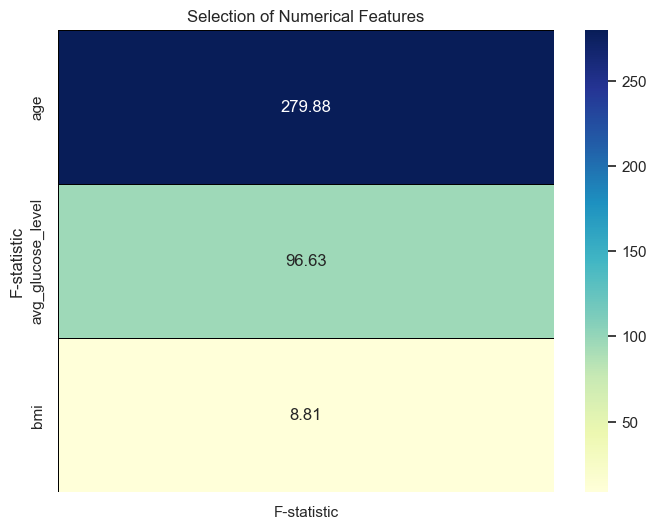

In [59]:
import pandas as pd
from scipy.stats import f_oneway
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called traindata with categorical and numerical factors
categorical_factors = traindata[['gender', 'hypertension', 'heart_disease', 'ever_married', 'smoking_status']]
numerical_factors = traindata[['age', 'avg_glucose_level', 'bmi']]
stroke = traindata['stroke']

# Perform ANOVA test for each numerical feature
for col in numerical_factors.columns:
    print(f"ANOVA test results for '{col}':")
    for group_name, group_data in categorical_factors.groupby(stroke):
        group_values = [numerical_factors.loc[group_data.index, col] for group_name, group_data in categorical_factors.groupby(stroke)]
        f_statistic, p_value = f_oneway(*group_values)
        print(f"  Group '{group_name}': F-statistic={f_statistic:.2f}, p-value={p_value:.4f}")
    print()

# Instantiate SelectKBest with f_classif as the scoring function and k='all'
selector = SelectKBest(score_func=f_classif, k='all')

# Fit the selector to your data
selector.fit(numerical_factors, stroke)

# Get the scores of the features
feature_scores = pd.DataFrame(data=selector.scores_, index=numerical_factors.columns, columns=['F-statistic'])

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(feature_scores.sort_values(by='F-statistic', ascending=False), annot=True, cmap='YlGnBu', linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Selection of Numerical Features')
plt.ylabel('F-statistic')
plt.show()


To evaluate numerical features, we used the ANOVA test to determine if there are statistically significant differences among them. The F-statistic is a number used in ANOVA tests that helps us figure out if there are big differences between the averages of three or more groups. It looks at how much the averages vary within each group compared to how much they vary between the groups. A higher F-statistic means the differences between the groups are more likely to be real and not just random chance. The p-value tells us how likely it is to see the results we got if there were actually no differences between the groups. A lower p-value means there's stronger evidence that the differences we see are real. If the p-value is really low (usually less than 0.05), we say there's a significant difference between the groups.

Based on our findings, we observed the following:

- **Age**:
    - Both groups ('0' and '1') have the same F-statistic value (279.88) and extremely low p-values (0.0000). This indicates that there is a significant difference in age between the two groups. In other words, age is likely a significant factor in predicting stroke risk.
    
    
- **Average Glucose Level**:
    - Similar to age, both groups have the same F-statistic value (96.63) and extremely low p-values (0.0000). This suggests that there is a significant difference in average glucose levels between the two groups. Elevated average glucose levels may also be a significant predictor of stroke risk.
    
- **BMI (Body Mass Index)**:
    - In contrast to age and average glucose level, both groups have the same F-statistic value (8.81) and relatively low p-values (0.0030). This indicates that there is a significant difference in BMI between the two groups, although not as strong as for age and average glucose level. BMI could still be considered a significant predictor of stroke risk, though to a lesser extent.

In summary, the F-statistic helps us understand if there are significant differences between group means, while the p-value tells us the likelihood of observing these differences if there were no real differences between the groups. Based on the provided insights, age and average glucose level appear to be significant predictors of stroke risk, while BMI also shows significance, albeit to a lesser degree.

### 2.3.3 Feature selection for numerical features (Random Forest)

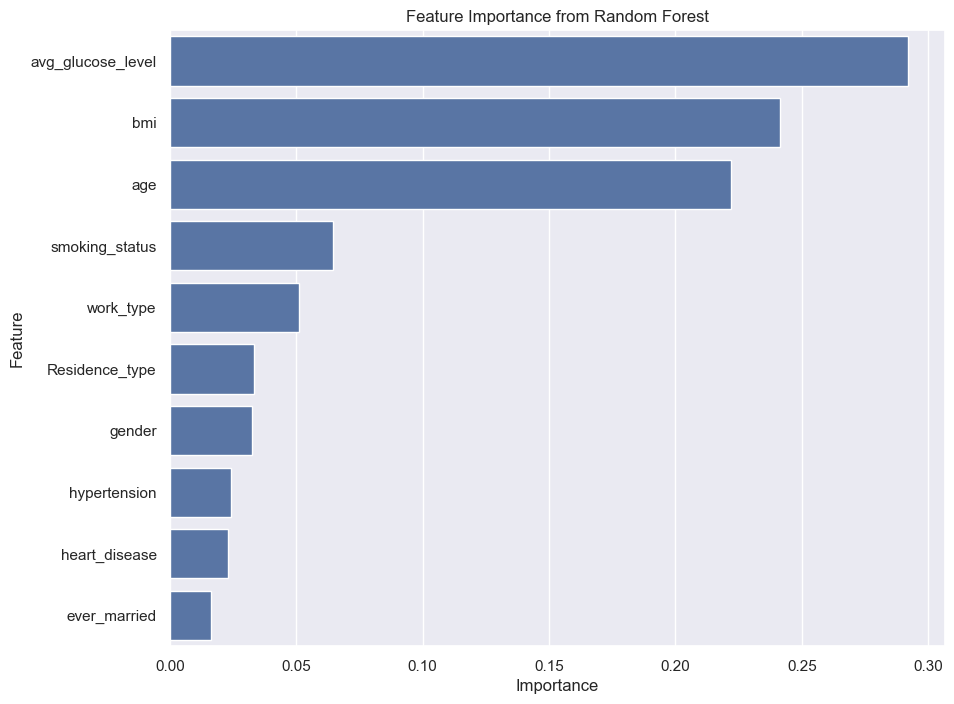

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Define the feature matrix X and the target y
X = traindata.drop(columns='stroke')
y = traindata['stroke']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(data=importances_df, x='Importance', y='Feature', color='b')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The features are ranked by their importance, with `avg_glucose_level`, `age`, and `BMI` being identified as the top three most influential features. These findings corroborate our observations from the correlation heatmap. However, the Random Forest model offers additional insights by considering non-linear relationships and interactions among features. This approach provides a more comprehensive understanding of feature importance, allowing us to capture nuanced patterns and dependencies within the data.

The differences observed in the results between the Random Forest model and the ANOVA test can be attributed to their distinct methodologies and capabilities. ANOVA, being a statistical method, evaluates the significance of differences in means across multiple groups by assuming linearity and normality in the data. In contrast, Random Forest, as a machine learning algorithm, is more flexible and capable of capturing complex nonlinear relationships and interactions between features. This allows Random Forest to consider not only the individual significance of features but also their combined predictive power, which may include interactions that ANOVA cannot detect. Furthermore, Random Forest does not rely on strict assumptions about the data distribution, making it more robust to violations of normality or heteroscedasticity. Consequently, while ANOVA assesses the significance of differences between groups' means, Random Forest evaluates feature importance based on predictive performance, providing a more comprehensive view of the data. Therefore, the differences in results between these two approaches are not necessarily contradictory but rather reflect their respective methodologies and strengths.

Hence, we cannot outrightly deduce that `bmi` is an insignifcant feature.

### Mutual information test with SelectKBest

In [61]:
# import pandas as pd
# from sklearn.feature_selection import SelectKBest, mutual_info_classif
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming you have a DataFrame called categorical_factors with categorical variables
# # and another DataFrame called stroke with the outcome variable 'stroke'

# # Instantiate SelectKBest with mutual_info_classif as the scoring function and k='all'
# selector = SelectKBest(score_func=mutual_info_classif, k='all')

# # Fit the selector to your data
# selector.fit(categorical_factors, stroke)

# # Get the mutual information scores of the features
# feature_scores = pd.DataFrame(data=selector.scores_, index=categorical_factors.columns, columns=['Mutual Information Score'])

# # Plot the heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(feature_scores.sort_values(by='Mutual Information Score', ascending=False), annot=True, cmap='YlGnBu', linewidths=0.4, linecolor='black', fmt='.2f')
# plt.title('Mutual Information Scores for Categorical Features')
# plt.xlabel('Categorical Features')
# plt.ylabel('Mutual Information Score')
# plt.show()